
# Feature Selection

<font size=4>**Feature selection** can be an important part of model selection. In supervised learning, including features in a model which do not provide information on the label is useless at best and may prevent generalization at worst.

Feature selection can involve application of several methods. Two important methods include:
1. Eliminating features with **low variance** and **zero variance**. Zero variance features are comprised of the same values. Low variance features arise from features with most values the same and with few unique values. **<font color=blue>One way low variance features can arise, is from dummy variables for categories with very few members. The dummy variable will be mostly 0s with very few 1s.<br><br></font>** 
2. Training ML models with features that are **uninformative** can create problems. An uninformative feature does not significantly improve model performance. In many cases, the noise in the uninformative features will increase the variance of the model predictions. <br>**<font color=blue>In other words, uninformative models are likely to reduce the ability of the machine learning model to generalize.**  <br> 
    </font>
****


<font size=4>**Note:** the second case of feature selection involves applying a selection statistic or hypothesis test multiple times. For large number of features, this process is very likely to lead to false positive and false negative results. This likely outcome is known as the **multiple comparisons problem** in statistics.<br><br>

To understand this problem, consider the decision to keep a feature in a model as a hypothesis test. Any hypothesis test has some probability of both a false positive result and a false negative result. Consider a case where there are 40 uninformative features which are excluded from the model with 95% confidence. There will be an approximately 5% chance of accepting a feature which should be rejected. In this case we would expect about 2 uninformative features to be accepted because of these errors. 

You may well ask, if testing features for importance can fail with large numbers of features, what is the alternative? The most general and scalable alternative is to use regularization methods. Consider applying regularization methods to a linear model. In this case, machine learning algorithm learns which features should be weighted highly and which should not. 
****

## Load the dataset

You will now apply the aforementioned principles to the bank credit data set. 

As a first step, run the code in the cell below to load the required packages. 

In [1]:
import pandas as pd
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
from sklearn import feature_selection as fs
from sklearn import metrics
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math

%matplotlib inline

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

<font size=4>Next, load the preprocessed files containing the features and the labels. The preprocessing includes the following:
1. Clean missing values.
2. Aggregate categories of certain categorical variables. 
3. Encode categorical variables as binary dummy variables.
4. Standardize numeric variables. 

Execute the code in the cell below to load the features and labels as numpy arrays for the example. 

In [2]:
Features = np.array(pd.read_csv('../input/credit-risk/Credit_Features.csv'))
Labels = np.array(pd.read_csv('../input/credit-risk/Credit_Labels.csv'))
print(Features.shape)
print(Labels.shape)

(1000, 35)
(1000, 1)


In [3]:
df_features = pd.read_csv('../input/credit-risk/Credit_Features.csv')
df_labels = pd.read_csv('../input/credit-risk/Credit_Labels.csv')



In [4]:
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,-1.864869,-0.933901,0.918477,2.271006,0,1,0,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,1.708369,1.163046,-0.870183,-1.446152,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,-0.673790,-0.181559,-0.870183,1.226696,0,0,0,1,0,1,...,0,1,0,0,1,0,0,0,1,0
3,1.478913,1.525148,-0.870183,0.942455,0,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
4,0.517289,0.904743,0.024147,1.488620,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1


In [5]:
df_labels.head()

,0
0,0
1,1
2,0
3,0
4,1


In [6]:
result = pd.merge(df_features, df_labels)


## Eliminate low variance features

<font size=4>As a fist step in selecting features from this dataset you will remove features with low variance. The `VarianceThreshold` function from the scikit-learn `feature_selection` package identifies features with less than some threshold of unique values. For a probability that a feature is unique $p$ the threshold is specified as;

$$Var(x) = p(1-p)$$

In this case a 80%, or $p=0.8$, threshold is used. 

The `fit_transform` method applies the threshold to the variance of each feature and removes features with variance below the threshold. The `get_support_` attribute shows the `True` and `False` logical for inclusion of each feature. 

Execute the code, examine the result, and answer **Question 1** on the course page. 

###  fs is feature selection. It contains the fit method where we pass the data
### we have set the threshold and then we notice 17 low variance features.  Features is the name of the dataframe      

In [7]:
print(Features.shape)

## Define the variance threhold and fit the threshold to the feature array. 
sel = fs.VarianceThreshold(threshold=(.8 * (1 - .8)))
Features_reduced = sel.fit_transform(Features)

## Print the support and shape for the transformed features
print(sel.get_support())
print(Features_reduced.shape)

(1000, 35)
[ True  True  True  True  True  True False  True False  True  True False
 False False  True False False False False False  True False False  True
 False False  True False  True False  True  True  True  True False]
(1000, 18)


## <font color=green>How many low variance features are there? Count the number of False 

## Answer: Number of low variance features = 17

<b><font size=4>The number of features has been reduced from 35 to 18 due to the threshold set. Apparently, there are 17 low variance features in the original array. Only 18 are true

 # Select k best features -use of Cross Validation

##>Select k best features -use of Cross Validation

The low variance features have been eliminated. But, the question remains, are all these features informative? There are a number of methods used to determine the importance of features. Many machine learning models have specialized methods to determine feature importance specifically intended for those methods. 

In this example, you will use a fairly general and robust method using cross validation. The algorithm is straight forward. Features are recursively removed.  Cross validation is used to find the change in model performance, if any, to determine if a feature should be deleted altogether.**</font><br><br>

The code in the cell below performs the following processing:
1. Create the folds for the cross validation for feature selection. These folds should be independent of any other cross validation performed. 
2. The logistic regression model is defined. 
3. **The `RFECV` function from the scikit-learn `feature_selection` package is used to determine which features to retain using a cross validation method. Notice that AUC is used as the model selection metric as the labels are imbalanced. In this case, the default, accuracy is a poor choice.** </font>
4. The RFECV feature selector is fit to the data. 

For how class_weight works: It penalizes mistakes in samples of class[i] with class_weight[i] instead of 1. So higher class-weight means you want to put more emphasis on a class.

<b>from ms model selection, we pass the parameter n_splits=10 and shuffle=true for the 18 features selected to the Logistic Regressio model

<b>>we use the algorithm Logistic Regression

In [8]:
## Reshape the Label array
Labels = Labels.reshape(Labels.shape[0],)

## Set folds for nested cross validation
nr.seed(988)
feature_folds = ms.KFold(n_splits=10, shuffle = True)

## Define the model
logistic_mod = linear_model.LogisticRegression(C = 10, class_weight = {0:0.45, 1:0.55}) 

## Perform feature selection by CV with high variance features only
nr.seed(6677)
selector = fs.RFECV(estimator = logistic_mod, cv = feature_folds,
                      scoring = 'roc_auc')
selector = selector.fit(Features_reduced, Labels)
selector.support_ 

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True])

**From the support you can see that some features are selected (True) and eliminated (False). you want to rank the features that were selected**. 

**Execute the code below to see the relative ranking of the features.**

In [9]:
selector.ranking_

array([1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1])

<b>Notice that the features which have been selected are shown with a rank of 1. The features eliminated are shown with higher numbers. the features with numbers 2 and 3 can be removed  

The code in the cell below as uses the `transform` method applies the selector to the feature array. 

In [10]:
Features_reduced = selector.transform(Features_reduced)
Features_reduced.shape

(1000, 16)

<b>The features have been reduced from the 18 high variance features to 16. Two features have been found to be unimportant. 

The code in the cell below creates a plot of AUC (the metric) vs. the number of features. Execute this code. 
    
Logistic Regression is a Classification model. In this application we are checking if the loan is good or bad. we are using the classification matrix- that is the ROC curve    

Text(0.5, 0, 'Number of features')

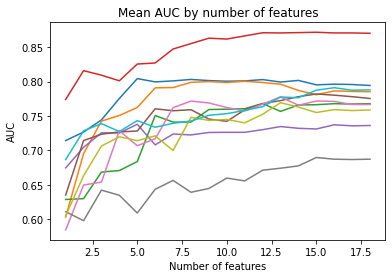

In [11]:
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.title('Mean AUC by number of features')
plt.ylabel('AUC')
plt.xlabel('Number of features')

>Notice that the change in AUC is not that great across a range of features around the 16 selected. 

## Apply nested cross validation to create model

<font size=4>The next step is to use nested cross validation to optimize the model hyperparameter and test the model performance. The model is constructed using the features selected. 

As a first step, construct the inside and outside folds for the nested cross validation by running the code in the cell below. 

In [12]:
nr.seed(123)
inside = ms.KFold(n_splits=10, shuffle = True)
nr.seed(321)
outside = ms.KFold(n_splits=10, shuffle = True)

The code in the cell below performs the grid search for the optimal model hyperparameter. As before, the scoring metric is AUC.Earlier we ha used C=10(this is the sweeping parameter we saw in the ppt)..now we use a parameter grid and give different values for C. Since it was unbalanced, we need to give it a weight 0.45 and 0.55   

<font size=4><b><font color=green>Exercise: try changing the weight

In [13]:
nr.seed(3456)
## Define the dictionary for the grid search and the model object to search on
param_grid = {"C": [0.1, 1, 10, 100, 1000]}
## Define the logistic regression model
logistic_mod = linear_model.LogisticRegression(class_weight = {0:0.45, 1:0.55}) 

## Perform the grid search over the parameters
clf = ms.GridSearchCV(estimator = logistic_mod, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      scoring = 'roc_auc',
                      return_train_score = True)

## Fit the cross validated grid search over the data 
clf.fit(Features_reduced, Labels)

## And print the best parameter value
clf.best_estimator_.C

10

The optimal value of the hyperparameter is 10. This parameter is larger than for the same model with all the features. Recalling that the parameter is the inverse of regularization strength, the smaller parameter means the model with fewer features requires less regularization. 

To get a feel for the results of the cross validation execute the code in the cell below and observe the results. 

Performance metrics by parameter
Parameter   Mean performance   STD performance
    0.10        0.77984            0.05047
    1.00        0.78412            0.04875
   10.00        0.78431            0.04815
  100.00        0.78411            0.04850
 1000.00        0.78403            0.04864


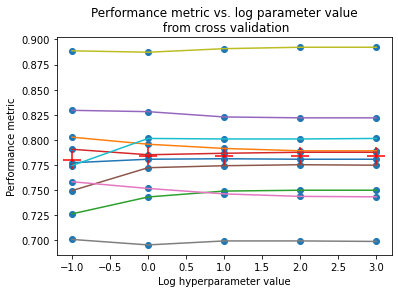

In [14]:
def plot_cv(clf, params_grid, param = 'C'):
    params = [x for x in params_grid[param]]
  
    keys = list(clf.cv_results_.keys())              
    grid = np.array([clf.cv_results_[key] for key in keys[6:16]])
    means = np.mean(grid, axis = 0)
    stds = np.std(grid, axis = 0)
    print('Performance metrics by parameter')
    print('Parameter   Mean performance   STD performance')
    for x,y,z in zip(params, means, stds):
        print('%8.2f        %6.5f            %6.5f' % (x,y,z))
    
    params = [math.log10(x) for x in params]
    
    plt.scatter(params * grid.shape[0], grid.flatten())
    p = plt.scatter(params, means, color = 'red', marker = '+', s = 300)
    plt.plot(params, np.transpose(grid))
    plt.title('Performance metric vs. log parameter value\n from cross validation')
    plt.xlabel('Log hyperparameter value')
    plt.ylabel('Performance metric')
    
plot_cv(clf, param_grid)    

Notice that the mean AUCs are within 1 standard deviation of each other. The AUC for the hyperparameter value of 10 is not significantly better than the other values tested. <b><font color=blue>note log scale is used to diplay the results

Now you will perform the outer loop of the nested cross validation by executing the code in the cell below. 

In [15]:
nr.seed(498)
cv_estimate = ms.cross_val_score(clf, Features, Labels, 
                                 cv = outside) # Use the outside folds
print('Mean performance metric = %4.3f' % np.mean(cv_estimate))

print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
print('Outcomes by cv fold')
for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

Mean performance metric = 0.780
SDT of the metric       = 0.039
Outcomes by cv fold
Fold  1    0.770
Fold  2    0.730
Fold  3    0.754
Fold  4    0.764
Fold  5    0.790
Fold  6    0.828
Fold  7    0.733
Fold  8    0.859
Fold  9    0.806
Fold 10    0.767


<font size=4>The performance metric is not significantly different than for the inner loop of  the cross validation. 

## Test the model

<font size=4>With the features selected and the optimal hyperparameters estimated, it is time to test the model. the code in the cell below does the following processing;
1. Split the reduced feature subset of the data into training and test subsets.
2. Define and fit a model using the optimal hyperparameter. 

Execute this code.

In [16]:
## Randomly sample cases to create independent training and test data
nr.seed(1115)
indx = range(Features_reduced.shape[0])
indx = ms.train_test_split(indx, test_size = 300)
X_train = Features_reduced[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
X_test = Features_reduced[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

## Define and fit the logistic regression model
logistic_mod = linear_model.LogisticRegression(C = 10, class_weight = {0:0.45, 1:0.55}) 
logistic_mod.fit(X_train, y_train)

LogisticRegression(C=10, class_weight={0: 0.45, 1: 0.55})

Next, execute the code in the cell below to score the model and display a sample of the resulting probabilities. 

In [17]:
def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])

probabilities = logistic_mod.predict_proba(X_test)
print(probabilities[:15,:])
scores = score_model(probabilities, 0.3)

[[0.94167243 0.05832757]
 [0.86258794 0.13741206]
 [0.64932039 0.35067961]
 [0.44101686 0.55898314]
 [0.94707474 0.05292526]
 [0.92040225 0.07959775]
 [0.71131955 0.28868045]
 [0.27825905 0.72174095]
 [0.20612969 0.79387031]
 [0.95227899 0.04772101]
 [0.62221142 0.37778858]
 [0.91862781 0.08137219]
 [0.28045922 0.71954078]
 [0.93132439 0.06867561]
 [0.93009926 0.06990074]]


<font size=4>With the model scored, execute the code in the cell below to display performance metrics for the model. 

                 Confusion matrix
                 Score positive    Score negative
Actual positive       128                84
Actual negative        16                72

Accuracy        0.67
AUC             0.80
Macro precision 0.68
Macro recall    0.71
 
           Positive      Negative
Num case      212            88
Precision    0.89          0.46
Recall       0.60          0.82
F1           0.72          0.59


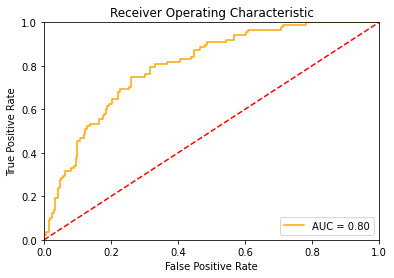

In [18]:
def print_metrics(labels, probs, threshold):
    scores = score_model(probs, threshold)
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy        %0.2f' % sklm.accuracy_score(labels, scores))
    print('AUC             %0.2f' % sklm.roc_auc_score(labels, probs[:,1]))
    print('Macro precision %0.2f' % float((float(metrics[0][0]) + float(metrics[0][1]))/2.0))
    print('Macro recall    %0.2f' % float((float(metrics[1][0]) + float(metrics[1][1]))/2.0))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])

def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()    
        
print_metrics(y_test, probabilities, 0.3)    
plot_auc(y_test, probabilities)   

<font size=4>At first glance, these performance metrics look quite good. Notice however, that the AUC is much larger than achieved with cross validation. This indicates that these results are overly optimistic, a common situation when a single split is used to evaluate a model. 

## <font color=green>TASK 2: What is the AUC of the model? 

## Answer: The AUC of the model is .....

## Summary

<font size=4>In this lab you have performed two types of feature selection:
1. Eliminating low variance features, which by their nature cannot be highly informative since they contain a high fraction of the same value.
2. Using recursive feature elimination, a cross validation technique for identifying uninformative features. 

With a reduced feature set less regularization was required for the model. This is expected since the most uninformative features have already been eliminated. It should be noted that for large numbers of features, these types of feature elimination algorithms should not be expected to give good generalization performance as a result of the multiple comparisons problem. In these cases, stronger regularization is a better approach. 
    
wE USED FEATURE SELECTION AND CROSS VALIDATION TO REMOVE FEATURES THAT HAVE LOW INFO CONTENT
    